Predicting Wine Quality Based on Main features with Main Features
====================================

In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
wine = pd.read_csv('winequality_red.csv', sep = ';')

In [70]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Converting quality value into binary data. 

In [71]:
bins = (2, 6.5, 8)
group_name = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_name)

In [56]:
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])
print(wine['quality'].value_counts())

0    1382
1     217
Name: quality, dtype: int64


### Preparing Training and Test Data

In [57]:
x = wine.drop('quality', axis = 1)
y = wine['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                    random_state = 42 )

In [58]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# (1) Setp 1 - Conducting Simple Analysis without Setting Parameter

In [63]:
basic_models = [GaussianNB(), LogisticRegression(), SVC(), 
                tree.DecisionTreeClassifier(), RandomForestClassifier(n_estimators=200),
               KNeighborsClassifier(5)]
model_list = ['bayes_model', 'logit', 'svm', 'decision_tree','random_forest', 'knn']

simple_test_result =  []

for i in basic_models:
    train = i.fit(x_train, y_train)
    prediction = i.predict(x_test)
    simple_test_result.append(metrics.accuracy_score(y_test,prediction))
    
result_table = pd.DataFrame(simple_test_result, columns = ['accuracy score'], index = model_list)

result_table.sort_values(by = ['accuracy score'], ascending = False, inplace = True)
print(result_table)

               accuracy score
random_forest        0.896875
decision_tree        0.881250
knn                  0.881250
svm                  0.875000
logit                0.865625
bayes_model          0.846875


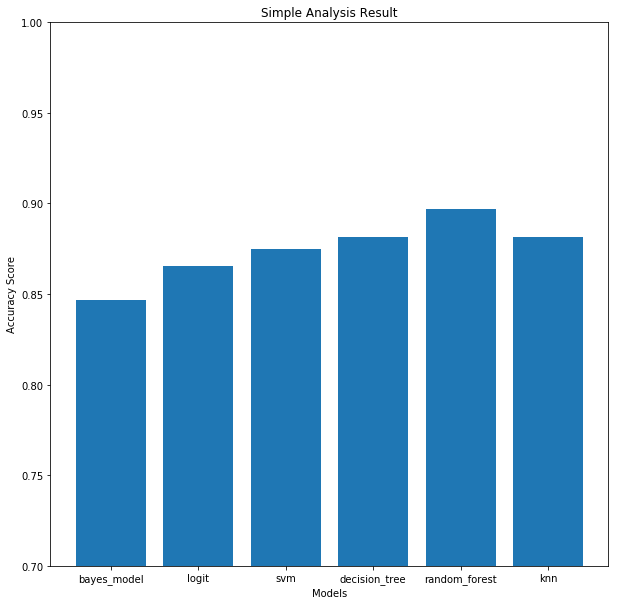

In [83]:
plt.figure(figsize = (10,10))
plt.bar(model_list, simple_test_result)
plt.title('Simple Analysis Result')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0.7, 1)
plt.show();

# Step2 - Searching Optimal Model Parameter

### 1)Decision Tree

In [9]:
param_grid = {'max_depth': [3, 10]}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

tree.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [10]:
tree.best_params_

{'max_depth': 3}

In [11]:
tree_best = DecisionTreeClassifier(max_depth = 3)
tree_best.fit(x_train, y_train)
tree_pred = tree_best.predict(x_test)
print(metrics.accuracy_score(y_test,tree_pred))

0.859375


### 2) Random Forest

In [12]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [13]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [15]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [16]:
rfc1.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [17]:
pred=rfc1.predict(x_test)

In [18]:
metrics.accuracy_score(y_test,pred)

0.878125

### 3) Supportive Vector Machine

In [46]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
              'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),
              'shrinking':(True,False)}
clf = GridSearchCV(svm, param_grid = parameters, scoring='accuracy')
clf.fit(x_train,y_train)



GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4], 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
clf.best_params_

{'C': 1.2,
 'decision_function_shape': 'ovo',
 'gamma': 1,
 'kernel': 'rbf',
 'shrinking': True}

In [50]:
svm1 = SVC(C=1.2, kernel= 'rbf', gamma= 1, shrinking=True, decision_function_shape='ovo', random_state=None)
svm1.fit(x_train, y_train)

SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
prediction = svm1.predict(x_test)
print(metrics.accuracy_score(y_test,prediction))

0.9


### 4) KNN

In [23]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors':[4,5,6,7],
              'leaf_size':[1,3,5],
              'n_jobs':[-1]}

#Fit the model
model = GridSearchCV(knn, param_grid=param_grid)
model.fit(x_train,y_train)




GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [4, 5, 6, 7], 'leaf_size': [1, 3, 5], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
model.best_params_

{'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 4}

In [26]:
best_knn = KNeighborsClassifier(leaf_size = 1, n_jobs = -1, n_neighbors = 4)

In [28]:
best_knn_model = best_knn.fit(x_train, y_train)
prediction = best_knn_model.predict(x_test)
print(metrics.accuracy_score(y_test,prediction))

0.88125


### 5) Logistic Regression

In [36]:
grid={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
      "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
logreg_cv.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [39]:
best_logreg = LogisticRegression(penalty='l2', C=1.0)
best_logreg_model = best_logreg.fit(x_train, y_train)
prediction = best_logreg_model.predict(x_test)
print(metrics.accuracy_score(y_test,prediction))

0.865625


## 6) Naive Bayes Model

In [67]:
bayes = GaussianNB()
bayes_model = bayes.fit(x_train, y_train)
prediction = bayes_model.predict(x_test)
print(metrics.accuracy_score(y_test, prediction))

0.846875
